## Project Description </br>
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

### Data Description:
The data is from 90,189 players that installed the game while the AB-test was running. The variables are:
<ul>
<li>userid - a unique number that identifies each player.</li>
<li>version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).</li>
<li>sum_gamerounds - the number of game rounds played by the player during the first week after installation</li>
<li>retention_1 - did the player come back and play 1 day after installing?</li>
<li>retention_7 - did the player come back and play 7 days after installing?</li>
    
</ul> 
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.
<ol>
<li>AB Testing Process</li>
<li>Understanding business problem & data</li>
<li>Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)</li>
<li>Look summary stats and plots</li>
<li>Apply hypothesis testing and check assumptions</li><ul>
<li>Check Normality & Homogeneity</li>
<li>Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)</li></ul>
<li>Evaluate the results</li>
<li>Make inferences</li>
<li>Recommend business decision to your customer/director/ceo etc.</li>
    
</ol>    

## Packages and Data

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro
import scipy.stats as stats


import warnings
warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv(r".\cookie_cats.csv")

In [75]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


## Summary Stats

In [76]:
#Lets check for any userid duplicates
duplicates = df.userid.duplicated()
df[duplicates].count()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [77]:
#Lets investigate if there are any missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(10)


,Total,Percent
userid,0,0.0
version,0,0.0
sum_gamerounds,0,0.0
retention_1,0,0.0
retention_7,0,0.0


In [78]:
df.shape

(90189, 5)

In [79]:
#checking number of unique variables
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

In [80]:
# Summary Stats: sum_gamerounds
round(df.describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])[["sum_gamerounds"]].T,2)

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
sum_gamerounds,90189.0,51.87,195.05,0.0,0.0,1.0,3.0,6.0,11.0,16.0,25.0,40.0,67.0,134.0,493.0,49854.0


The gamer round max is abnormally high. That is something that will be investigated.

In [81]:
# A/B Groups & Target Summary Stats
df.groupby('version').sum_gamerounds.agg(['count','mean', 'median', 'std', 'min', 'max'])

,count,mean,median,std,min,max
version,,,,,,
gate_30,44700,52.456264,17.0,256.716423,0,49854
gate_40,45489,51.298776,16.0,103.294416,0,2640


In [82]:
round(pd.DataFrame(df.version.value_counts(normalize = True)*100),2)

,version
gate_40,50.44
gate_30,49.56


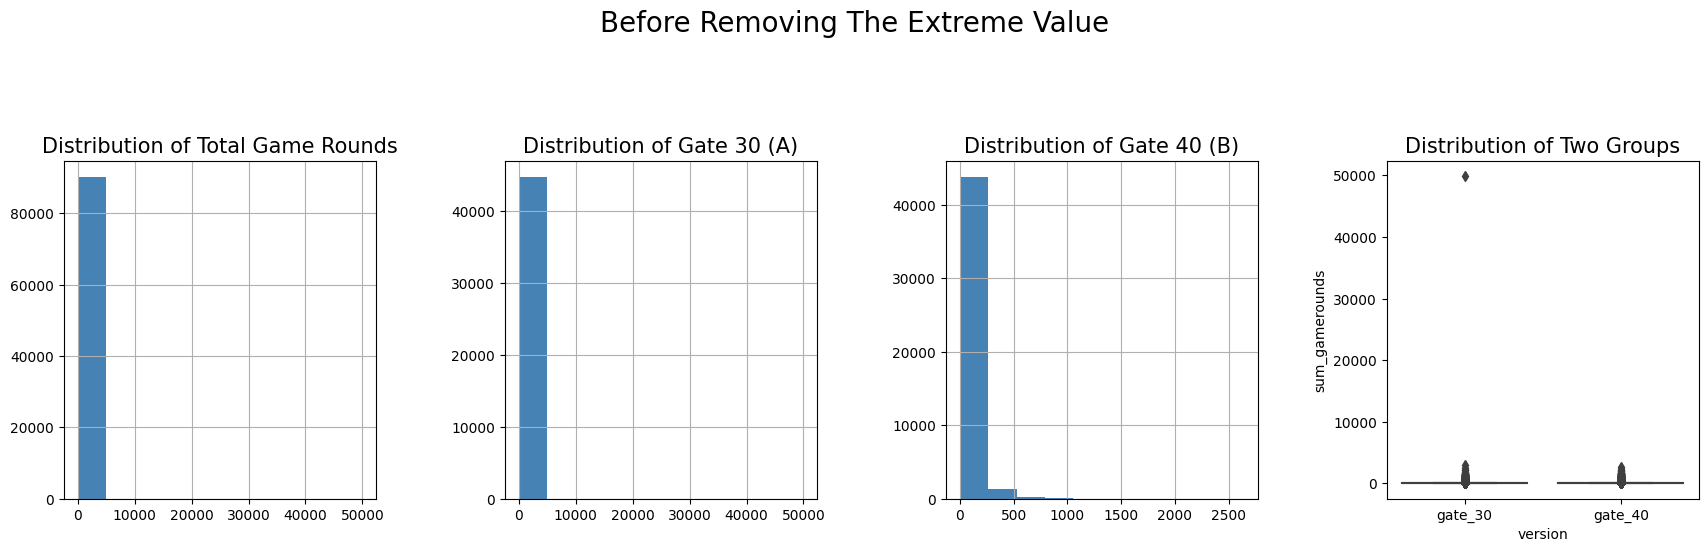

In [83]:
fig, axes = plt.subplots(1, 4, figsize = (18,6))
df.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

<AxesSubplot: >

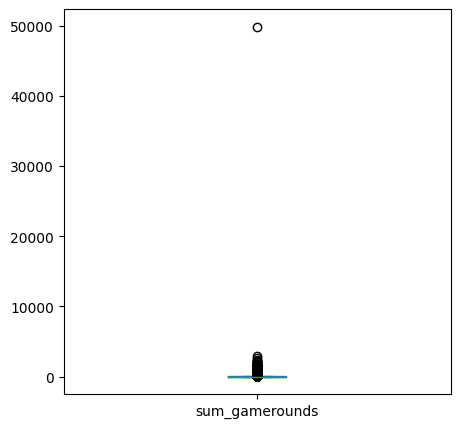

In [84]:
df['sum_gamerounds'].plot.box(figsize = (5,5))

<AxesSubplot: xlabel='index'>

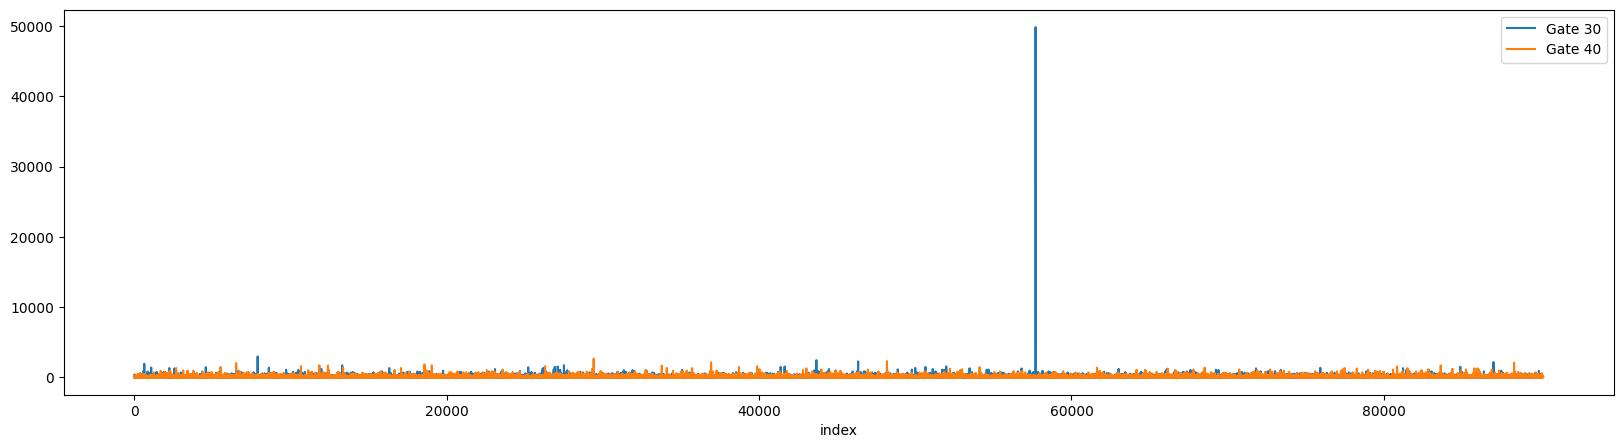

In [13]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")


## Outliers
Lets remove the outlier and investigate the distribution of data

In [14]:
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
round(df.describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])[["sum_gamerounds"]].T,2)

,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
sum_gamerounds,90188.0,51.32,102.68,0.0,0.0,1.0,3.0,6.0,11.0,16.0,25.0,40.0,67.0,134.0,493.0,2961.0


<AxesSubplot: >

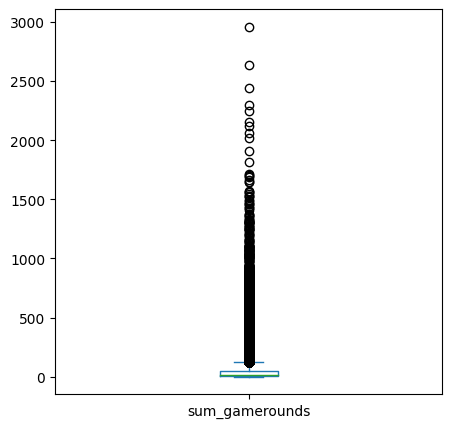

In [15]:
df['sum_gamerounds'].plot.box(figsize = (5,5))

<AxesSubplot: xlabel='index'>

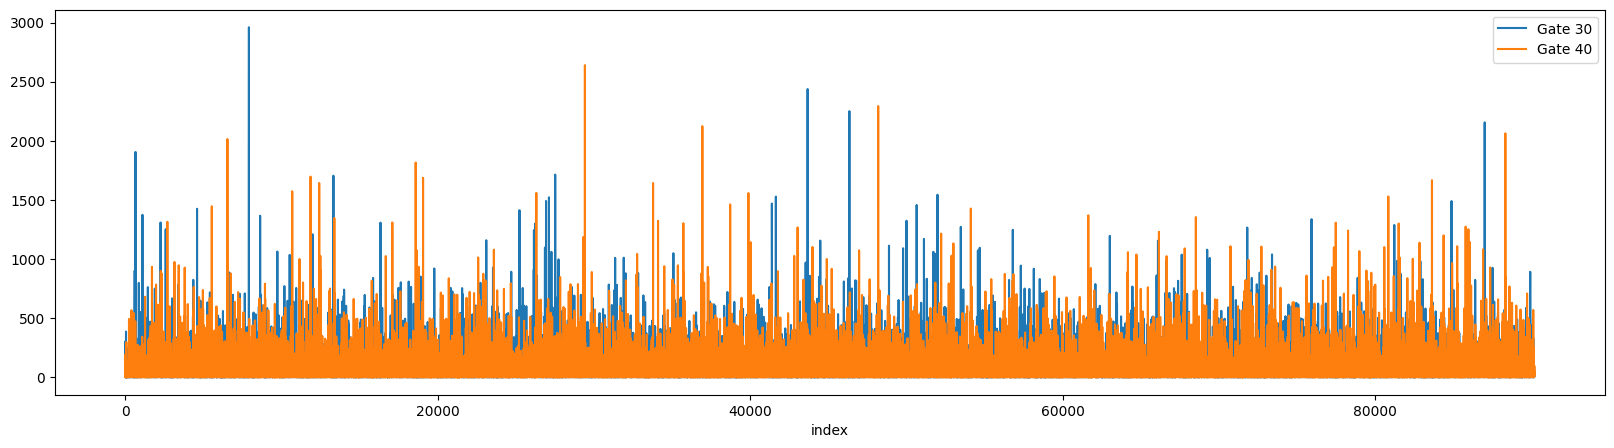

In [16]:
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")


### Exploratory Data Analysis

In [87]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()

Text(0.5, 0, '# Game Rounds')

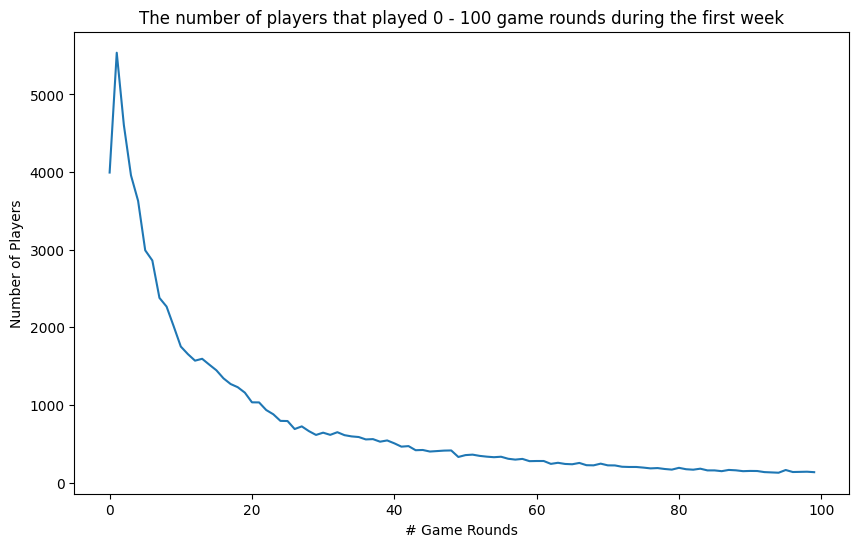

In [86]:
%matplotlib inline

ax = plot_df[:100].plot(figsize = (10,6))

ax.set_title('The number of players that played 0 - 100 game rounds during the first week')

ax.set_ylabel('Number of Players')
ax.set_xlabel('# Game Rounds')

In [19]:
Zero_rounds = df[df['sum_gamerounds'] == 0].count()
Zero_rounds

userid            3994
version           3994
sum_gamerounds    3994
retention_1       3994
retention_7       3994
dtype: int64

<AxesSubplot: xlabel='sum_gamerounds', ylabel='Density'>

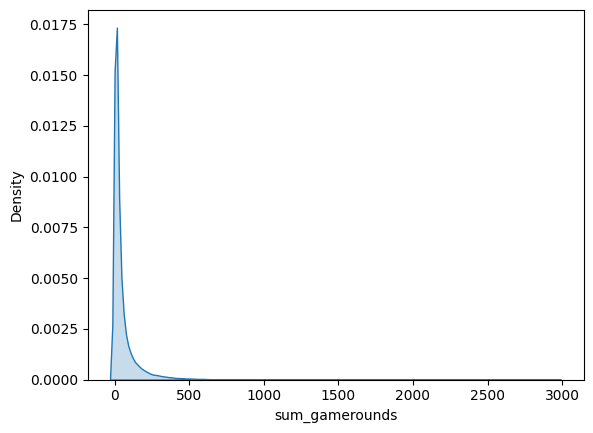

In [20]:
sns.kdeplot(df['sum_gamerounds'], shade=True)

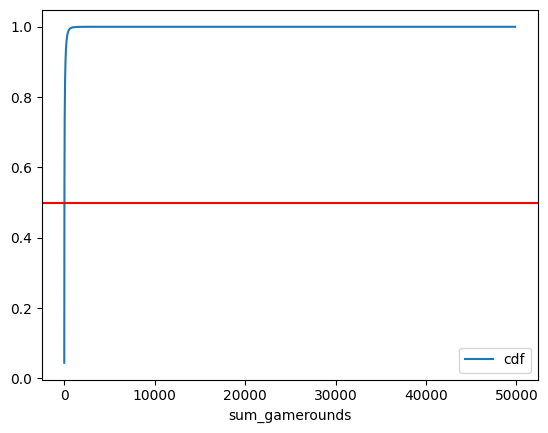

In [88]:
stats_df = df \
.groupby('sum_gamerounds') \
['sum_gamerounds'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'sum_gamerounds': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df

stats_df.plot(x = 'sum_gamerounds', y = 'cdf')
plt.axhline(y=0.5,color = 'red')
x50 = stats_df[stats_df['cdf'] >= 0.5]
x90 = stats_df[stats_df['cdf'] >= 0.9]

In [89]:
# at which level are 50% of the users?
x50.iloc[0]

sum_gamerounds      16.000000
frequency         1342.000000
pdf                  0.014880
cdf                  0.500216
Name: 16, dtype: float64

In [90]:
# at which level are 90% of the users?

x90.iloc[0]

sum_gamerounds    134.000000
frequency          80.000000
pdf                 0.000887
cdf                 0.900043
Name: 134, dtype: float64

<b> The users installed the game but 3994 users never played the game! Some reasons might explain this situation. </b>
<ul>
<li>They have no free time to play game </li>
<li>Users might prefer to play other games or they play other games already</li>
<li>Some users don't like the app etc.</li>
<li>The number of users decreases as the levels progress</li>
</ul>

<b>Most of users played the game at early stage and they didn't progress.</b>
<ul>
<li>Tactile Entertainment should learn why users churn playing the game.</li>
<li>Doing research and collecting data about the game and users would help to understand user churn</li>
<li>The difficulty of the game can be measured</li>
<li>Gifts might help player retention</li> </ul>

In [91]:
df.groupby('sum_gamerounds').userid.count().reset_index().head(10)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [26]:
df.groupby('sum_gamerounds').userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Looking at the summary statistics, the control and Test groups seem similar, but are the two groups statistically significant? We will investigate this statistically.

In [45]:
count30 = df[df['sum_gamerounds'] >= 30].userid.count()
count40 = df[df['sum_gamerounds'] > 40].userid.count()

total = df.count()

percentage_above_30 = round(count30/total[0] *100,2)
percentage_above_40 = round(count40/total[0] *100,2)


print(percentage_above_30, percentage_above_40)

36.89 29.81


In [95]:
round(df.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'min', 'max']),2)

,count,median,mean,std,min,max
version,,,,,,
gate_30,44700,17.0,52.46,256.72,0,49854
gate_40,45489,16.0,51.30,103.29,0,2640


In [94]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": round(df['retention_1'].value_counts(),2),
              "RET7_COUNT": round(df["retention_7"].value_counts(),2),
              "RET1_RATIO": round(df["retention_1"].value_counts() / len(df)*100,2),
              "RET7_RATIO": round(df["retention_7"].value_counts() / len(df) *100,2)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50036,73408,55.48,81.39
True,40153,16781,44.52,18.61


<b> Retention variables gives us player retention details.</b>
<ul>
    <li>retention_1 - did the player come back and play 1 day after installing?</li>
<li>retention_7 - did the player come back and play 7 days after installing?</li>
    </ul>
<b>Also players tend not to play the game! There are many players who quit the game.</b>
<ul>
<li>55 percent of the players didn't play the game 1 day after installing </li>
<li>81 percent of the players didn't play the game 7 day after installing</li>
       </ul>

In [96]:
round(df.groupby(['version', 'retention_1']).sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'min', 'max']),2)

count  median   mean     std  min    max
version retention_1                                          
gate_30 False        24666     6.0  18.38  319.42    0  49854
        True         20034    48.0  94.41  135.04    0   2961
gate_40 False        25370     6.0  16.34   35.93    0   1241
        True         20119    49.0  95.38  137.89    0   2640

Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

In [97]:
round(df.groupby(['version', 'retention_7']).sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'min', 'max']),2)

count  median    mean     std  min    max
version retention_7                                           
gate_30 False        36198    11.0   25.80   43.32    0    981
        True          8502   105.0  165.96  568.00    0  49854
gate_40 False        37210    11.0   25.86   44.41    0   2640
        True          8279   111.0  165.65  183.79    0   2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

In [98]:
df["Retention"] = np.where((df.retention_1 == True) & (df.retention_7 == True), 1,0)
round(df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"]),2)

count  median    mean     std    max
version Retention                                      
gate_30 0          38024    12.0   29.38  259.99  49854
        1           6676   127.0  183.89  189.63   2961
gate_40 0          38983    12.0   28.10   48.93   2640
        1           6506   133.0  190.28  194.22   2294

When the retention variables are combined and the two groups are compared, the summary statistics are similar here as well

In [99]:
df["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), df.retention_1, df.retention_7))
round(df.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index(),2)

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.82,21.64,981
1,gate_30,False-True,1826,43.0,100.43,1168.68,49854
2,gate_30,True-False,13358,33.0,49.69,58.13,918
3,gate_30,True-True,6676,127.0,183.89,189.63,2961
4,gate_40,False-False,23597,6.0,11.91,20.90,547
5,gate_40,False-True,1773,47.0,75.26,94.48,1241
6,gate_40,True-False,13613,32.0,50.03,60.92,2640
7,gate_40,True-True,6506,133.0,190.28,194.22,2294


## A/B Testing

#### Assumptions: 
<ul>
    <li> Check normaility</li>
    <li> If Normal Distribution, check homogeneity </li> </ul>

<b> Steps: </b>
<ul>
    <li>Split & Define Control Group & Test Group</li>
    <li>Apply Shapiro Test for normality</li>
    <li>If parametric apply Levene Test for homogeneity of variances</li>
    <li>If Parametric + homogeneity of variances apply T-Test</li>
    <li>If Parametric - homogeneity of variances apply Welch Test</li>
    <li>If Non-parametric apply Mann Whitney U Test directly</li></ul>
        

In [61]:
df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [70]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
        
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


### Conclusion
<b> Remember business problem! </b>


<u> As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.</u>

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.

Before A/B Testing, we shared some details about game, players, problems and suggestion to our customer/director/ceo etc.

After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Briefly, There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.

Which level has more advantages in terms of player retention?
1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.

In [100]:
df.groupby("version").retention_1.mean(), df.groupby("version").retention_7.mean()

(version
 gate_30    0.448188
 gate_40    0.442283
 Name: retention_1, dtype: float64,
 version
 gate_30    0.190201
 gate_40    0.182000
 Name: retention_7, dtype: float64)

The gate should be at level 30 but average retentions look like similar. We need more data for similarity.